In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import os
import pickle
from glob import glob
from os.path import join
import numpy as np

In [2]:
base_dir = '../'

In [3]:
def index_names(name):

    patterns = [
        (r'.*beam_l-na_r-na', 'beam'),
        (r'.*greedy_l-na_r-na', 'greedy'),
        (r'.*predfuse_es_l-0-3_r-na', 'es03'),
        (r'.*predfuse_es_l-0-5_r-na', 'es05'),
        (r'.*predfuse_es_l-0-7_r-na', 'es07'),
        (r'.*rsa_l-na_r-0-5', 'rsa05'),
        (r'.*rsa_l-na_r-1-0', 'rsa10'),
        (r'.*rsa_l-na_r-5-0', 'rsa50'),
        (r'.*annsample', 'ann'), 
        (r'.*predfuse_es_l-0-1_r-na', 'es01'),
        (r'.*predfuse_es_l-0-2_r-na', 'es02'),
        (r'.*predfuse_es_l-0-4_r-na', 'es04'),
        (r'.*predfuse_es_l-0-6_r-na', 'es06'),
        (r'.*predfuse_es_l-0-8_r-na', 'es08'),
        (r'.*predfuse_es_l-0-9_r-na', 'es09'),
    ]
    
    for pattern, replace in patterns:
        name = re.sub(pattern, replace, name)
    
    return name

def reformat_index(
    df, 
    ordered_index=[
            'ann', 'greedy', 'beam', 
            'es09', 'es08', 'es07', 
            'es06', 'es05', 'es04', 
            'es03', 'es02', 'es01', 
            'rsa05', 'rsa10', 'rsa50'
            ]
    ):

    df.index = df.index.map(index_names)
    df.index = pd.Categorical(df.index, 
                              categories=ordered_index,
                              ordered=True)
    return df

def mcn2df(list_of_files): 
    mcn_df = pd.DataFrame()

    for file in sorted(list_of_files):
        with open(file) as f:
            data = f.read()

        seg_result = float(re.search(seg_pattern, data).group(1))
        det_result = float(re.search(det_pattern, data).group(1))
        ie_result = float(re.search(ie_pattern, data).group(1))

        name = os.path.split(file)[-1].replace('_cleaned_filtered.txt', '')

        mcn_df = mcn_df.append(pd.Series(
            {'segmentation': seg_result*100, 'detection': det_result*100, 'IE': ie_result},
            name=name
        ))
        
    def get_split(x):
        return x.split('_')[2]
        
    mcn_df['split'] = mcn_df.index.map(get_split)

    return mcn_df

def get_index_vals(series):
    return series.index.to_list(), list(series.values)

def annotate_max(x, y, ax, line):
    color = line[0].get_color()
    
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    
    ax.scatter(xmax,ymax,marker='x',facecolor=color)

seg_pattern = r'iou: (\d\.\d+)'
det_pattern = r'Acc@\.5: (\d\.\d+)'
ie_pattern = r'IE score : (\d\.\d+)'

/tmp/ipykernel_16140/22522273.py:54: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True)


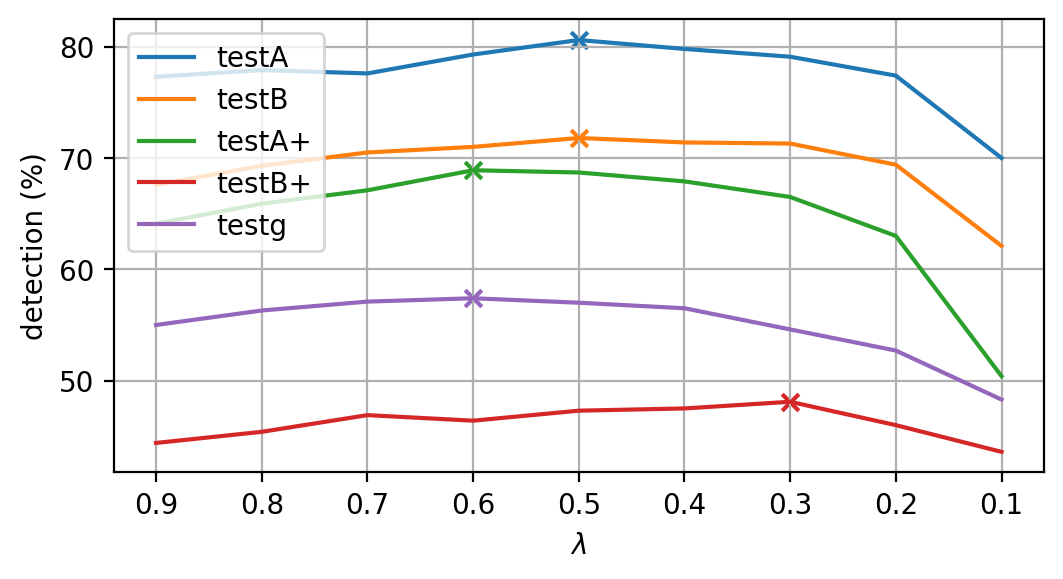

In [4]:
save = False  # set to true in order to export graph
    

mcn_path =  join(base_dir, 'data', 'mcn_results')
gridsearch_path = join(mcn_path, 'gridsearch')

fig, ax = plt.subplots(figsize=(6,3), dpi=200)

# RefCOCO

gridsearch_files = glob(gridsearch_path+'/*refcoco_*')
gridsearch_mcn = mcn2df(gridsearch_files).round(1)
gridsearch_mcn = reformat_index(gridsearch_mcn).sort_index()

idx, vals = get_index_vals(gridsearch_mcn.loc[gridsearch_mcn.split == 'testA'].detection)
line = plt.plot(idx, vals, label='testA')
annotate_max(idx, vals, ax, line)

idx, vals = get_index_vals(gridsearch_mcn.loc[gridsearch_mcn.split == 'testB'].detection)
line = plt.plot(idx, vals, label='testB')
annotate_max(idx, vals, ax, line)

# RefCOCO+

gridsearch_files = glob(gridsearch_path+'/*refcoco+_*')
gridsearch_mcn = mcn2df(gridsearch_files).round(1)
gridsearch_mcn = reformat_index(gridsearch_mcn).sort_index()

idx, vals = get_index_vals(gridsearch_mcn.loc[gridsearch_mcn.split == 'testA'].detection)
line = plt.plot(idx, vals, label='testA+')
annotate_max(idx, vals, ax, line)

idx, vals = get_index_vals(gridsearch_mcn.loc[gridsearch_mcn.split == 'testB'].detection)
line = plt.plot(idx, vals, label='testB+')
annotate_max(idx, vals, ax, line)

# RefCOCOg

gridsearch_files = glob(gridsearch_path+'/*refcocog_*')
gridsearch_mcn = mcn2df(gridsearch_files).round(1)
gridsearch_mcn = reformat_index(gridsearch_mcn).sort_index()

idx, vals = get_index_vals(gridsearch_mcn.loc[gridsearch_mcn.split == 'test'].detection)
line = plt.plot(idx, vals, label='testg')
annotate_max(idx, vals, ax, line)

# plot

labels = (.9,.8,.7,.6,.5,.4,.3,.2,.1)
ax.set_xticks(range(9))
ax.set_xticklabels(labels)
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel('detection (%)')
ax.grid(b=True)

#ax.set_ylim(40,90)

plt.legend(loc='upper left') # loc=''

if save:
    plt.savefig('es_gridsearch.png', bbox_inches='tight')

plt.show()